In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import scipy.stats as sts

import time as tm
import sys

plt.rcParams.update({'font.size': 14})
#plt.rcParams.update({'figure.figsize': (6,4)})

# Delta-hedging

the idea is to verify if delta hedging really works. One must verify that self-financing portfolio minus option actually follows a deterministic path (or something around it)

In [2]:
T = 1

S0 = 120
mu = 0.10
sigma = 0.2

K  = 120
r  = 0.05

kind_opt = 'call'

# Basic idea

We have a _covered position_ built by buying an option and shorting a portfolio able to _replicate_ the value of the option in time. The option price is indicated by $C_t$, while the portfolio is composed by $h_t$ stocks with price $S_t$ and $b_t$ dollars in a cash account with value $B_t:=\exp{rt}$. Define the value of the covered position as $I_t$:
$$ I_t = h_t S_t + b_t B_t - C_t$$
and we want that position to be _hedged_, meaning that market risk should not influence its value. In other words, it should evolve deterministically without generating arbitrages with the other deterministic player, that is $B_t$, so $I_t = I_0\exp{rt}$. The replication portfolio is built exactly to accomplish this task, and in their original paper, Black and Scholes prove that $h_t$ and $b_t$ must have specific dynamics. $I_0$ should then be null, if the replication portfolio is really doing so. This market is continuous, and for this reason the final value 

Also, its dynamics should respect the idea that the option changes its value solely by market risk and by the presence in the market of $B_t$, because money is never injected in the option position. This suggests that:
$$\text d(h_tS_t+b_tB_t) = h_t\text dS_t + b_t\text dB_t,$$
that is the condition defining a _self-financing_ portfolio. Recall that $S_t$ is a Geometric Brownian Motion, while $h_t$ is equal to $C_{S,t}$, that is the random process defined as the derivative of the option price at time $t$. Expand LHS between $t$ and $t+\delta t$ and state again the equality:
$$\text d(h_tS_t+b_tB_t) = 
h_{t+\delta t}S_{t+\delta t} - h_tS_t + b_{t+\delta t}B_{t+\delta t} - b_tB_t =
h_tS_{t+\delta t} - h_t\text S_t + b_tB_{t+\delta t} - b_t B_t\Rightarrow
b_t - (h_{t+\delta t} - h_t)B_{t+\delta t}^{-1}S_{t+\delta t} = b_{t+\delta t}.$$
This means that to respect the self-financing behaviour, in the same istant when the new prices $S_{t+\delta t}$ and $B_{t+\delta t}$ are available, the position in the risk-free asset (money market) should be adjusted of a factor $ - (h_{t+\delta t} - h_t)B_{t+\delta t}^{-1}S_{t+\delta t}$ and the stock position of a factor $h_{t+\delta t}-h_t$. $I_T$ may not be exactly equal to $I_0e^{rT}=0$, when time is discretised.

One can also track the evolution of a cash process. The idea is:

0. start from $m$ money, and buy the option, and short the replication portfolio. At now, cash should be still equal to $m$.
1. at each $i$-th time step, sell $h_i-h_{i-1}$ stocks for $S_i$, and sell also $h_i-h_{i-1}$ bonds for $B_i$. This is by definition the delta-hedging strategy, so che cash process is representing the PnL of the trader.
2. _After_ the last time step collect the payoff and close the short positions in stock and bond.

As the portfolio can replicate the option, this means that the cash at last time step should be equal to what we did with cash. If it was stored in an interest paying money account, it should be equal to $me^{rT}$, otherwise should be just stayed equal to $m$. Time discretisation introduces an error, called _hedging error_.

# Base functions
1. ``option`` computes fundamental quantities about the option
2. ``delta_hedge`` computes the evolution of the covered position

Note that one can set ``null_balance`` to ``True`` or ``False``. The second case represents the standard way to describe no-arbitrage conditions, with a portfolio that starts with null value and should end up so. The first case is introduced just to prove that if the covered position had some cash not placed anywhere at the beginning, it should grow at the same rate of the risk-free account.

In [3]:
def option(S, K, r, sigma, maturity, kind = 'call'):
    d_1   = (np.log(S/K)+(r+sigma**2/2)*maturity)/(sigma*np.sqrt(maturity))
    d_2   = d_1 - sigma*np.sqrt(maturity)
    if kind == 'call':
        ct    = S*sts.norm.cdf(d_1)-K*np.exp(-r*maturity)*sts.norm.cdf(d_2)
        delta = sts.norm.cdf(d_1)
        gamma = sts.norm.pdf(d_1)/(sigma*S*np.sqrt(maturity))
        theta = -S*sts.norm.pdf(d_1)*sigma/2/np.sqrt(maturity)-r*K*np.exp(-r*maturity)*sts.norm.cdf(d_2)
    if kind == 'put':
        ct    = -S*sts.norm.cdf(-d_1)+K*np.exp(-r*maturity)*sts.norm.cdf(-d_2)
        delta = sts.norm.cdf(d_1) - 1
        gamma = sts.norm.pdf(d_1)/(sigma*S*np.sqrt(maturity))
        theta = -S*sts.norm.pdf(d_1)*sigma/2/np.sqrt(maturity)+r*K*np.exp(-r*maturity)*sts.norm.cdf(-d_2)
    return ct, delta, gamma, theta, d_1

def delta_hedge(realizzazioni, N, S0, K, r, mu, sigma, T, seeder = None, null_balance = False, kind = 'call'):
    if seeder is not None: np.random.seed(seeder) 
    
    N = min(N,65536) # just to avoid weird memory issues
    
    time, step, dt  = np.linspace(0,T,N+1), np.linspace(0,N,N+1), T/N
    St, bt, cash, Z = [ np.empty((realizzazioni,N+1)) for i in range(3) ] + [ np.random.normal(size = (realizzazioni,N+1)) ]
    
    Bt = np.exp(r*time)
    St[:,0] = S0
    for i in range(1,N+1):
        St[:,i] = St[:,i-1]*np.exp( (mu-sigma**2/2)*dt + sigma*np.sqrt(dt)*Z[:,i] )
    Ct, hx, gamma, theta, d1 = option(St, K, r, sigma, T - time, kind)
    payoff = np.maximum(St[:,N]-K,0) if kind == 'call' else np.maximum(K-St[:,N],0)
    
    bt[:,0] = Ct[:,0]-hx[:,0]*S0        
    for i in range(1,N+1):
        bt[:,i] = bt[:,i-1] - ( hx[:,i] - hx[:,i-1] )*St[:,i]/Bt[i]
    
    It = - Ct + hx*St + bt*Bt
    
    cash[:,0] = 100*(not null_balance) - Ct[:,0] + hx[:,0]*St[:,0] + bt[:,0]*Bt[0]
    for i in range(1,N+1):
        cash[:,i] = cash[:,i-1]*np.exp(r*dt) + ( hx[:,i] - hx[:,i-1] )*St[:,i] + ( bt[:,i] - bt[:,i-1] )*Bt[i]
    cash[:,N] += payoff - hx[:,N-1]*St[:,N] - bt[:,N-1]*Bt[N]
    
    return step, time, St, Bt, Ct, It, hx, bt, cash, gamma, theta, d1

# Covered position

The covered position evolves quite closely to the risk-free asset.

In [4]:
start = tm.time()

# 2 OTM
# 1 ITM

N = 1024
step, time, St, Bt, Ct, It, hx, bt, cash, gamma, theta, d1 = delta_hedge(1, N, S0, K, r, mu, sigma, T, 1, True, kind_opt)

print("elapsed: ",tm.time()-start)

elapsed:  0.03191399574279785


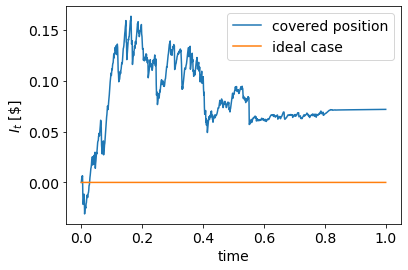

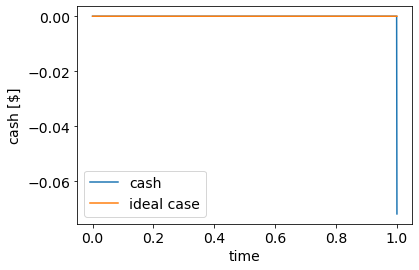

In [5]:
plt.xlabel("time")
plt.ylabel(r"$I_t$ [$\$$]")

plt.plot(time,It[0], label = 'covered position')
plt.plot(time,It[0,0]*np.exp(r*time), label = 'ideal case')
plt.legend()
plt.show()

plt.xlabel("time")
plt.ylabel(r"cash [$\$$]")

plt.plot(time,cash[0], label = 'cash')
plt.plot(time,cash[0,0]*Bt, label = 'ideal case')
plt.legend()
plt.show()

# P&L

Consider an instantaneous change of value of the option and the short position on stocks from time $t$ to time $t+\delta t$, before one can readjust. See _Gamma Hedging_ from _Encyclopedia of Quantitative Finance_ (Rama Cont) for the derivation:
$$P\&L:=\frac{\Gamma_t}2\left(\delta S_t^2-\sigma^2S_t^2\delta t\right)$$

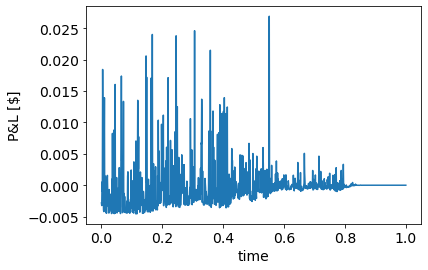

In [6]:
plt.xlabel("time")
plt.ylabel(r"P&L [$\$$]")

plt.plot(time[1:],0.5*gamma[0,:-1]*((St[0,1:]-St[0,:-1])**2-St[0,:-1]**2*sigma**2*time[-1]/(len(time)-1)))
plt.show()

# Hedging error for different time steps

The time discretisation error introduced a slight mismatch between $I_T$ and $I_0e^{rT}$, and such mismatch will have its mean and variance. One can run a large enough Monte Carlo simulation and measure its empirical distribution as a function of the number of MC realizations, and just for fun compare it to a Gaussian with identical mean and variance.

One can also consider the root mean square associated to the hedging error, and see how it scales with the time step. It scales like the square root of the number of time steps, somehow resembling the traditional MC-CLT scaling.

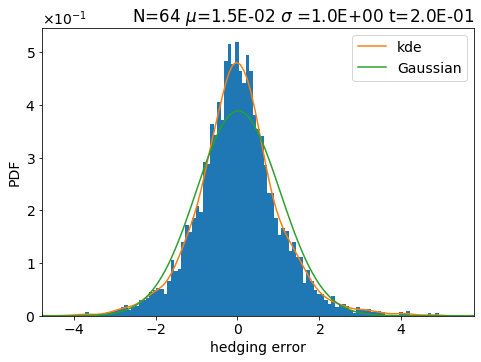

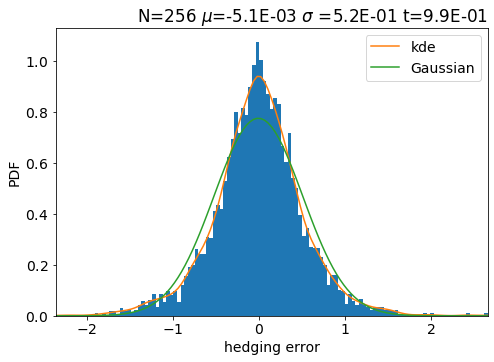

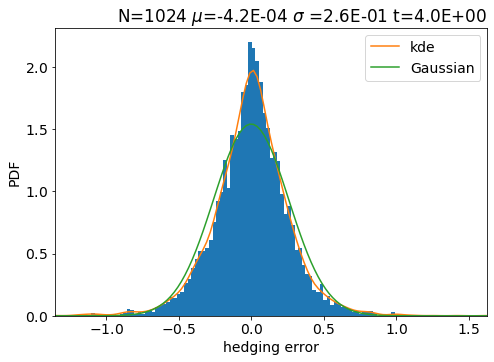

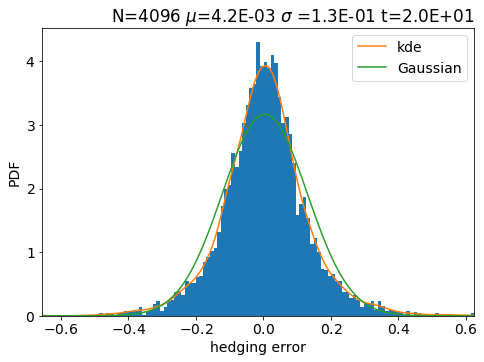

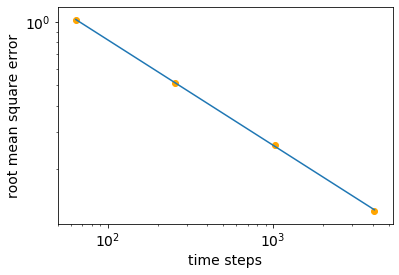

In [7]:
realizations = 5000

N_values = np.array([4**i for i in range(3,7)])
error = np.array([])
tot = np.array([])

for N in N_values:
    start = tm.time()
    
    step, time, St, Bt, Ct, It, hx, bt, cash, gamma, theta, d1 = delta_hedge(realizations, N, S0, K, r, mu, sigma, T, 10101, True)
    hedging_error = cash[:,N]-cash[:,0]*np.exp(r*T)
    
    X_plot = np.linspace(hedging_error.min(),hedging_error.max(),121)
    kernel = sts.gaussian_kde(hedging_error)
    kde = kernel(X_plot).T
    
    tot = np.append(tot,tm.time() - start)
    
    
    fig = plt.figure()
    ax1 = fig.add_axes([0,0,1,1])
    
    plt.xlabel("hedging error")
    plt.ylabel("PDF")
    plt.xlim((X_plot[0],X_plot[-1]))
    
    plt.hist(hedging_error, density = True, bins = 121)        
    plt.plot(X_plot,kde,label = 'kde')
    plt.plot(X_plot,sts.norm.pdf(X_plot,scale = hedging_error.std(), loc = hedging_error.mean()),label = 'Gaussian')
    
    ax1.ticklabel_format(axis = 'x',style='sci',scilimits=(-3,3),useOffset=True,useMathText=True)
    ax1.ticklabel_format(axis = 'y',style='sci',scilimits=(0,3),useOffset=True,useMathText=True)
    plt.title((r"N={:d} $\mu$={:.1E} $\sigma$ ={:.1E} t={:.1E}").format(N,hedging_error.mean(),hedging_error.std(),tot[-1]),loc='right')

    plt.legend()
    plt.show()
    
    error = np.append(error,np.sqrt((hedging_error**2).mean()))
    
plt.xscale("log")
plt.yscale("log")

plt.xlabel("time steps")
plt.ylabel(r"root mean square error")

plt.plot(N_values,error[0]*(N_values/N_values[0])**(-0.5))
plt.scatter(N_values,error,marker='o',color='orange')

plt.show()